<a href="https://colab.research.google.com/github/VaishnaviBalaji/Arrhythmia/blob/main/Arrhythmia_5fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [13]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM,GRU
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

#Matplotlib setup
plt.rcParams["figure.figsize"] = (9,3)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Reading the Input Data

In [14]:
path = '/content/drive/MyDrive/Dataset/mitbih_database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

##Reading files

In [15]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

##Seperating files and annotations

In [16]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Denoising

In [17]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) #max useful level of decomposition
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

#Reading R positions and Arrhythmia class

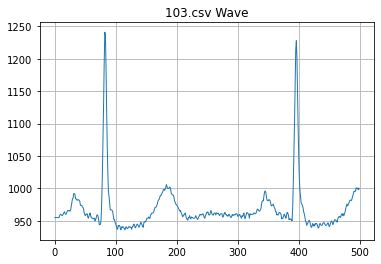

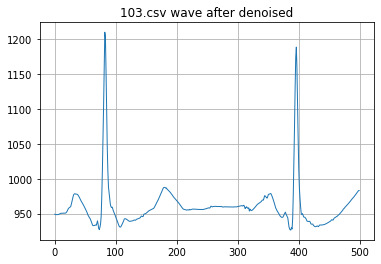

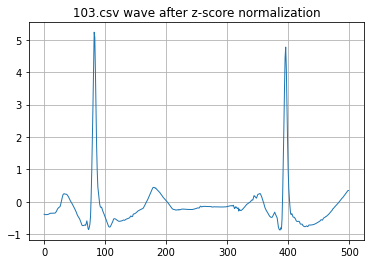

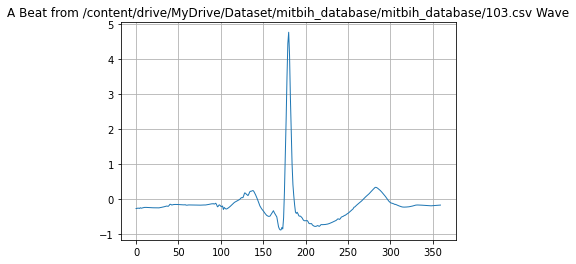

(100012, 360) (100012,)


In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("103.csv Wave")
        plt.plot(signals[0:500])
        #plt.grid(False)
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("103.csv wave after denoised")
        plt.plot(signals[0:500])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " 103.csv wave after z-score normalization ")
        plt.plot(signals[0:500])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[3] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [7]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


#Distribution of classes

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


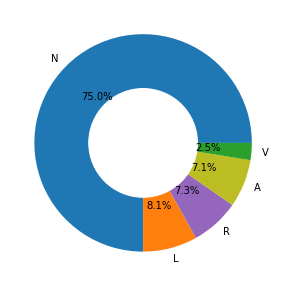

In [8]:
df = pd.DataFrame(X) #Array to df
per_class = df[df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#Train-Test split

In [9]:
train,test=train_test_split(df,test_size=0.20)
print("train : ", np.shape(train))
print("test  : ", np.shape(test))

train :  (80009, 361)
test  :  (20003, 361)


#Sampling Train Data

In [10]:
#down sampling class 0
df_0=(train[train[train.shape[1]-1]==0]).sample(7000,random_state=42)

#up sampling class 1
df_1=train[train[train.shape[1]-1]==1]
df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=23)

#up sampling class 2
df_2=train[train[train.shape[1]-1]==2]
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=23)

#up sampling class 3
df_3=train[train[train.shape[1]-1]==3]
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=23)

#up sampling class 4
df_4=train[train[train.shape[1]-1]==4]
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=23)


In [11]:
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

3.0    7000
4.0    7000
2.0    7000
1.0    7000
0.0    7000
Name: 360, dtype: int64


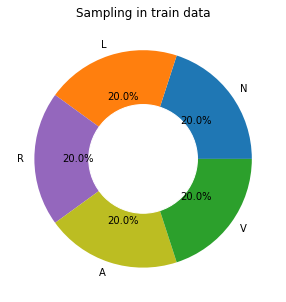

In [12]:
per_class = train_df[train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Sampling in train data")
plt.show()

In [18]:
train_df.shape

(35000, 361)

In [19]:
per_class = train_df[train_df.shape[1]-1].value_counts()
per_class

3.0    7000
4.0    7000
2.0    7000
1.0    7000
0.0    7000
Name: 360, dtype: int64

#Independent and Dependent variables in Test Data 

In [20]:
#test data 
test_x= test.iloc[:,:test.shape[1]-1].values
test_x=test_x.reshape(len(test_x), test_x.shape[1],1)
test_y= test[test.shape[1]-1]
test_y=to_categorical(test_y)

In [21]:
print("test_x : ", np.shape(test_x))
print("test_y  : ", np.shape(test_y))

test_x :  (20003, 360, 1)
test_y  :  (20003, 5)


0.0    14904
1.0     1655
4.0     1479
2.0     1464
3.0      501
Name: 360, dtype: int64


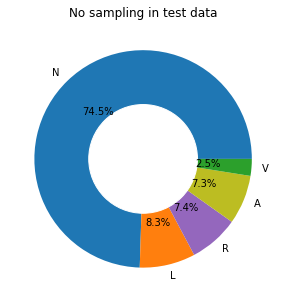

In [22]:
per_class = test[test.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("No sampling in test data")
plt.show()

#Independent and dependent varibale in Training Data

In [23]:
target_train=train_df[train_df.shape[1]-1] #label train
#target_val=val[val.shape[1]-1] #labes test
train_y=to_categorical(target_train)
#val_y=to_categorical(target_val)
print(np.shape(train_y))

(35000, 5)


In [24]:
train_x = train_df.iloc[:,:train_df.shape[1]-1].values
#val_x = val.iloc[:,:val.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
#val_x = val_x.reshape(len(val_x), val_x.shape[1],1)
print(np.shape(train_x))

(35000, 360, 1)


In [25]:
print("train_x : ", np.shape(train_x))
print("train_y  : ", np.shape(train_y))
#print("val x : ", np.shape(val_x))
#print("val y  : ", np.shape(val_y))

train_x :  (35000, 360, 1)
train_y  :  (35000, 5)


#CNN Model

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn.metrics as metrics

In [ ]:
def cnn_model():
  model = Sequential()
  model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
  model.add(AvgPool1D(pool_size=3, strides=2))
    
  model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
  model.add(Softmax())
    
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  model.summary()

  return model

cnn=cnn_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 64)           0

##CNN model plot

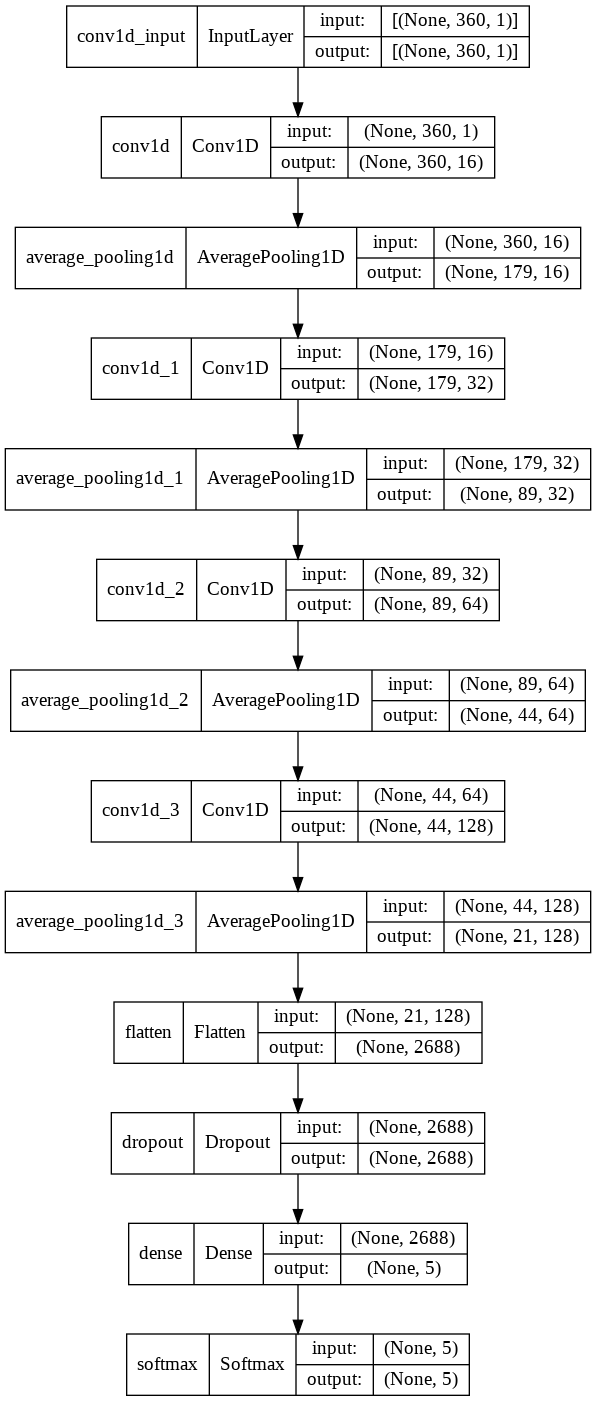

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##KFold cross validation

In [65]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) # Use for KFold classification
oos_y = []
oos_pred = []
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=cnn.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = cnn.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    


    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    # Generate generalization metrics
    scores = cnn.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    
 



Fold #1


Fold score (RMSE): 0.02972927689552307
Score for fold 1: loss of 0.01355179026722908; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.050771892070770264
Score for fold 2: loss of 0.02326655201613903; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.039492085576057434
Score for fold 3: loss of 0.01078715268522501; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.03742354363203049
Score for fold 4: loss of 0.009771090000867844; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.01673208549618721
Score for fold 5: loss of 0.007557776290923357; accuracy of 100.0%


In [66]:
average_acc=sum(acc_per_fold)/3
acc_per_fold.append(average_acc)
average_loss=sum(loss_per_fold)/3
loss_per_fold.append(average_loss)
average_rmse=sum(rmse_per_fold)/3
rmse_per_fold.append(average_rmse)

##Training data Evaluation summary

In [67]:
zipped=list(zip(acc_per_fold,loss_per_fold,rmse_per_fold))
df=pd.DataFrame(zipped,index=["Fold_1", "Fold_2", "Fold_3","Average"],columns=["Accuracy", "Loss", "RMSE"])
df

ValueError: ignored

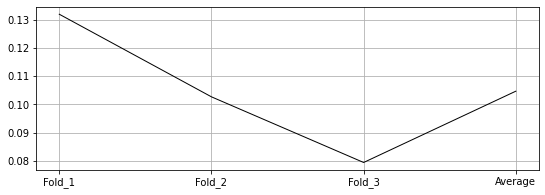

In [68]:
plt.plot(df['RMSE'], label='Train loss Fold 1', color='black')

##CNN Test Data Evaluation

###Test Loss and Accuracy

In [69]:
score = cnn.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 4s 6ms/step - loss: 0.0989 - accuracy: 0.9867
Test Loss: 0.09892664849758148
Test accuracy: 0.9867019653320312


In [70]:
y_pred = cnn.predict(test_x, batch_size=1000)

###Test Data classification report

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14992
           1       1.00      1.00      1.00      1583
           2       0.99      1.00      0.99      1444
           3       0.77      0.95      0.85       516
           4       0.95      1.00      0.97      1468

    accuracy                           0.99     20003
   macro avg       0.94      0.98      0.96     20003
weighted avg       0.99      0.99      0.99     20003



###Test Data Confusion Matrix

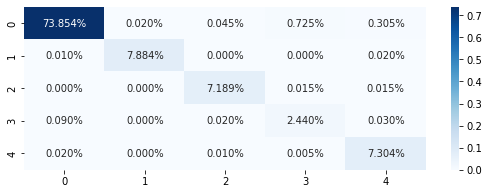

In [72]:
import seaborn as sns
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

#LSTM Model

In [73]:
def get_lstm():
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(360,1)))
    lstm_model.add(Dense(128, activation = 'relu'))
    lstm_model.add(Dropout(0.3))
    lstm_model.add(Dense(5, activation = 'softmax'))
    
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm_model.summary()
    return lstm_model

lstm=get_lstm()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________


##LSTM model plot

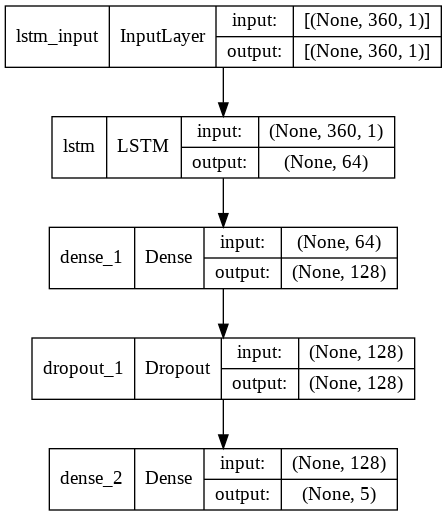

In [ ]:
plot_model(lstm, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

##KFold Cross Validation

In [74]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) # Use for KFold classification
oos_y = []
oos_pred = []
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=lstm.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = lstm.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    


    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    # Generate generalization metrics
    scores = lstm.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {lstm.metrics_names[0]} of {scores[0]}; {lstm.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    
 


Fold #1


Fold score (RMSE): 0.2217157632112503
Score for fold 1: loss of 0.5131842494010925; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.13381822407245636
Score for fold 2: loss of 0.17585785686969757; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.09939654916524887
Score for fold 3: loss of 0.09396840631961823; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.08494333922863007
Score for fold 4: loss of 0.06522205471992493; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.08219218999147415
Score for fold 5: loss of 0.06288827955722809; accuracy of 100.0%


##Training data Evaluation Summary

In [ ]:
lstm_average_acc=sum(acc_per_fold)/3
acc_per_fold.append(lstm_average_acc)
lstm_average_loss=sum(loss_per_fold)/3
loss_per_fold.append(lstm_average_loss)
lstm_average_rmse=sum(rmse_per_fold)/3
rmse_per_fold.append(lstm_average_rmse)

In [ ]:
zipped=list(zip(acc_per_fold,loss_per_fold,rmse_per_fold))
df=pd.DataFrame(zipped,index=["Fold_1", "Fold_2", "Fold_3","Average"],columns=["Accuracy", "Loss", "RMSE"])
df

,Accuracy,Loss,RMSE
Fold_1,100.0,1.590525,0.400452
Fold_2,100.0,1.397243,0.366501
Fold_3,100.0,0.678517,0.256113
Average,100.0,1.222095,0.341022


##LSTM Test Data Evaluation

###Test Loss and Accuracy

In [ ]:
score = lstm.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 16s 26ms/step - loss: 0.7203 - accuracy: 0.7504
Test Loss: 0.720295786857605
Test accuracy: 0.7504374384880066


In [ ]:
y_pred = lstm.predict(test_x, batch_size=1000)

###Test Data Classification Report

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     14992
           1       0.67      0.83      0.74      1583
           2       0.31      0.85      0.45      1444
           3       0.29      0.65      0.40       516
           4       0.71      0.82      0.76      1468

    accuracy                           0.75     20003
   macro avg       0.59      0.78      0.64     20003
weighted avg       0.87      0.75      0.78     20003



###Test Data Confusion matrix

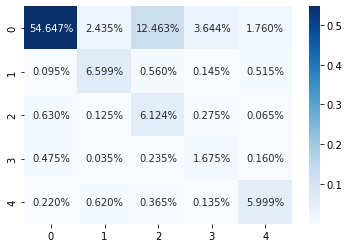

In [ ]:
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

#GRU Model

In [26]:
def get_gru():
    gru_model = Sequential()
    gru_model.add(GRU(64, input_shape=(360,1)))
    gru_model.add(Dense(128, activation = 'relu'))
    gru_model.add(Dropout(0.3))
    gru_model.add(Dense(5, activation = 'softmax'))
    
    gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

gru=get_gru()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21,829
Trainable params: 21,829
Non-trainable params: 0
_________________________________________________________________


##GRU Model Plot

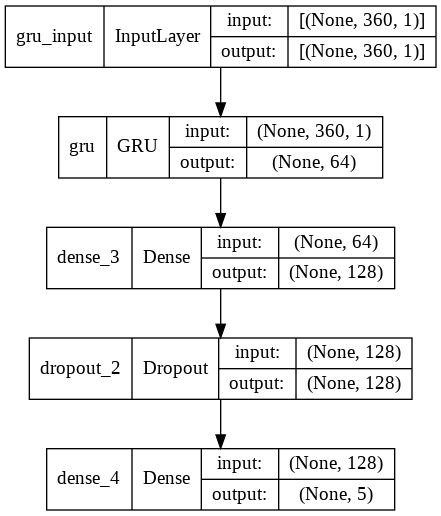

In [ ]:
plot_model(gru, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##KFold cross Validation

In [29]:
# Cross-Validate
kf = KFold(5, shuffle=True, random_state=42) # Use for KFold classification
oos_y = []
oos_pred = []
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
rmse_per_fold=[]
fold = 0
for train, test in kf.split(train_x,train_y):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train=train_x[train]
    y_train=train_y[train]
    x_test=train_x[test]
    y_test=train_y[test]
    
    history=gru.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=10)
    
    #cnn.append(fit_and_evaluate(x_train,x_test,y_train,y_test))
    print("======="*12, end="\n\n\n")
    pred = gru.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)  
    


    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    # Generate generalization metrics
    scores = gru.evaluate(x_test,pred, verbose=0)
    print(f'Score for fold {fold}: {gru.metrics_names[0]} of {scores[0]}; {gru.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

Fold #1


Fold score (RMSE): 0.14604929089546204
Score for fold 1: loss of 0.18371035158634186; accuracy of 100.0%
Fold #2


Fold score (RMSE): 0.12818531692028046
Score for fold 2: loss of 0.16410717368125916; accuracy of 100.0%
Fold #3


Fold score (RMSE): 0.09183162450790405
Score for fold 3: loss of 0.06388631463050842; accuracy of 100.0%
Fold #4


Fold score (RMSE): 0.07769696414470673
Score for fold 4: loss of 0.045706480741500854; accuracy of 100.0%
Fold #5


Fold score (RMSE): 0.07180766761302948
Score for fold 5: loss of 0.034966856241226196; accuracy of 100.0%


##Training Data Evaluation summary

In [30]:
average_acc=sum(acc_per_fold)/3
acc_per_fold.append(average_acc)
average_loss=sum(loss_per_fold)/3
loss_per_fold.append(average_loss)
average_rmse=sum(rmse_per_fold)/3
rmse_per_fold.append(average_rmse)

In [31]:
zipped=list(zip(acc_per_fold,loss_per_fold,rmse_per_fold))
df=pd.DataFrame(zipped,index=["Fold_1", "Fold_2", "Fold_3","Average"],columns=["Accuracy", "Loss", "RMSE"])
df

ValueError: ignored

##GRU Test Data Evaluation

###Test Loss and Accuracy

In [32]:
score = gru.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 17s 28ms/step - loss: 0.1410 - accuracy: 0.9631
Test Loss: 0.14099448919296265
Test accuracy: 0.9630555510520935


In [33]:
y_pred = gru.predict(test_x, batch_size=1000)

###Test Data classification Report

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(test_y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     14904
           1       0.99      0.98      0.99      1655
           2       0.98      0.99      0.98      1464
           3       0.52      0.92      0.67       501
           4       0.88      0.98      0.93      1479

    accuracy                           0.96     20003
   macro avg       0.87      0.97      0.91     20003
weighted avg       0.97      0.96      0.97     20003



###Test Data confusion matrix

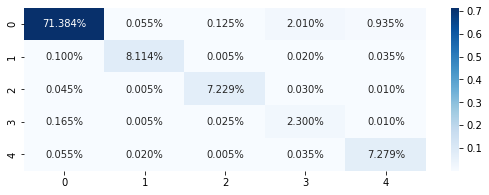

In [35]:
import seaborn as sns
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')